# Bigdata project Titanic - Machine Learning from Disaster

#ທ້າວ ບຸນມີ ປ່າໄຊ ແລະ ທ້າວ ບຸນມາຢ່າງ ປ່າວື

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=b243e8255802650b1e4d3fce2d6d7f844ff71bcfc983196be1de56c5a1d2f58d
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
from pyspark.sql.types import StructType, StructField, IntegerType
from pyspark.sql.functions import isnan, when, col,count,lit, regexp_extract, mean, avg, split
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
import pyspark

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (13,6)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
# ສ້າງເຊັດຊັນ pyspark
from pyspark.sql import SparkSession

MAX_MEMORY = '15G'
# Initialize a spark session.
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)

def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Pyspark guide") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()


In [ ]:
# ໄຟລ ແລະ ເສັ້ນທາງຂອງໄຟລ
file_location = "/dataset/train.csv"
# df = spark.read.csv(file_location, header=True, inferSchema=True)
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

In [ ]:
print('Data frame type: ' + str(type(df)))

Data frame type: <class 'pyspark.sql.dataframe.DataFrame'>


# ພາບລວມຂອງຂໍ້ມູນ

ຮູບແບບ, ຖັນ ແລະ ປະເພດຂອງຊຸດຂໍ້ມູນ:
ຊຸດຂໍ້ມູນມີທັງຖັນຄ່າດຽວ (int, string) ແລະ ຖັນທີ່ສ້າງຈາກ arraylist.

In [ ]:
df.describe().show()

+-------+-----------------+-------------------+------------------+--------------------+------+------------------+------------------+-------------------+------------------+-----------------+-----+--------+
|summary|      PassengerId|           Survived|            Pclass|                Name|   Sex|               Age|             SibSp|              Parch|            Ticket|             Fare|Cabin|Embarked|
+-------+-----------------+-------------------+------------------+--------------------+------+------------------+------------------+-------------------+------------------+-----------------+-----+--------+
|  count|              891|                891|               891|                 891|   891|               714|               891|                891|               891|              891|  204|     889|
|   mean|            446.0| 0.3838383838383838| 2.308641975308642|                NULL|  NULL| 29.69911764705882|0.5230078563411896|0.38159371492704824|260318.54916792738| 32.20420

In [ ]:
print('ພາບລວມຂອງຂໍ້ມູນ')
df.printSchema()
print('ພາບລວມຂອງຖັນ')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

ພາບລວມຂອງຂໍ້ມູນ
root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)

ພາບລວມຂອງຖັນ


,Column Name,Data type
0,PassengerId,int
1,Survived,int
2,Pclass,int
3,Name,string
4,Sex,string
5,Age,double
6,SibSp,int
7,Parch,int
8,Ticket,string
9,Fare,double


In [ ]:
print('ຂອບຂໍ້ມູນອະທິບາຍ (ຖັນສະຕຣິງ ແລະ ຕົວເລກເທົ່ານັ້ນ):')
df.describe().toPandas()

ຂອບຂໍ້ມູນອະທິບາຍ (ຖັນສະຕຣິງ ແລະ ຕົວເລກເທົ່ານັ້ນ):


,summary,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,count,891,891,891,891,891,714,891,891,891,891,204,889
1,mean,446.0,0.3838383838383838,2.308641975308642,None,None,29.69911764705882,0.5230078563411896,0.38159371492704824,260318.54916792738,32.2042079685746,None,None
2,stddev,257.3538420152301,0.48659245426485753,0.8360712409770491,None,None,14.526497332334035,1.1027434322934315,0.8060572211299488,471609.26868834975,49.69342859718089,None,None
3,min,1,0,1,"""Andersson, Mr. August Edvard (""""Wennerstrom"""")""",female,0.42,0,0,110152,0.0,A10,C
4,max,891,1,3,"van Melkebeke, Mr. Philemon",male,80.0,8,6,WE/P 5735,512.3292,T,S


In [ ]:
print(f'ມີທັງໝົດ {df.count()} ແຖວ, ໃຫ້ສະແດງຂໍ້ມູນ 3 ແຖວທຳອິດ:')
df.limit(3).toPandas()

ມີທັງໝົດ 891 ແຖວ, ໃຫ້ສະແດງຂໍ້ມູນ 3 ແຖວທຳອິດ:


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S


# ກວດຈັບຄ່າທີ່ຂາດຫາຍໄປ ແລະ ສູນຜິດປົກກະຕິ

In [ ]:
from pyspark.sql.functions import isnan, count, when, col
display(df.select([count(when(isnan(c)|col(c).isNull(),c)).alias(c) for c in df.columns]))

DataFrame[PassengerId: bigint, Survived: bigint, Pclass: bigint, Name: bigint, Sex: bigint, Age: bigint, SibSp: bigint, Parch: bigint, Ticket: bigint, Fare: bigint, Cabin: bigint, Embarked: bigint]

# ການວິເຄາະຂໍ້ມູນການສໍາຫຼວດ

ມີຈັກຄົນລອດຊີວິດ?

In [ ]:
df.groupBy("Survived").count().show()

+--------+-----+
|Survived|count|
+--------+-----+
|       1|  342|
|       0|  549|
+--------+-----+



ອັດຕາການຢູ່ລອດມີການພົວພັນກັນແນວໃດກັບຕົວແປ/ຄຸນສົມບັດບາງຢ່າງ:

ເພດ:

In [ ]:
df.groupBy("Sex","Survived").count().show()

+------+--------+-----+
|   Sex|Survived|count|
+------+--------+-----+
|  male|       0|  468|
|female|       1|  233|
|female|       0|   81|
|  male|       1|  109|
+------+--------+-----+



 Pclass:

In [ ]:
df.groupBy("Pclass","Survived").count().show()

+------+--------+-----+
|Pclass|Survived|count|
+------+--------+-----+
|     1|       0|   80|
|     3|       1|  119|
|     1|       1|  136|
|     2|       1|   87|
|     2|       0|   97|
|     3|       0|  372|
+------+--------+-----+



 ອາຍຸ

In [ ]:
df_pd = df.toPandas()

[Text(0.5, 0, 'Age Groups'), Text(0, 0.5, 'Number  of  Travelers')]

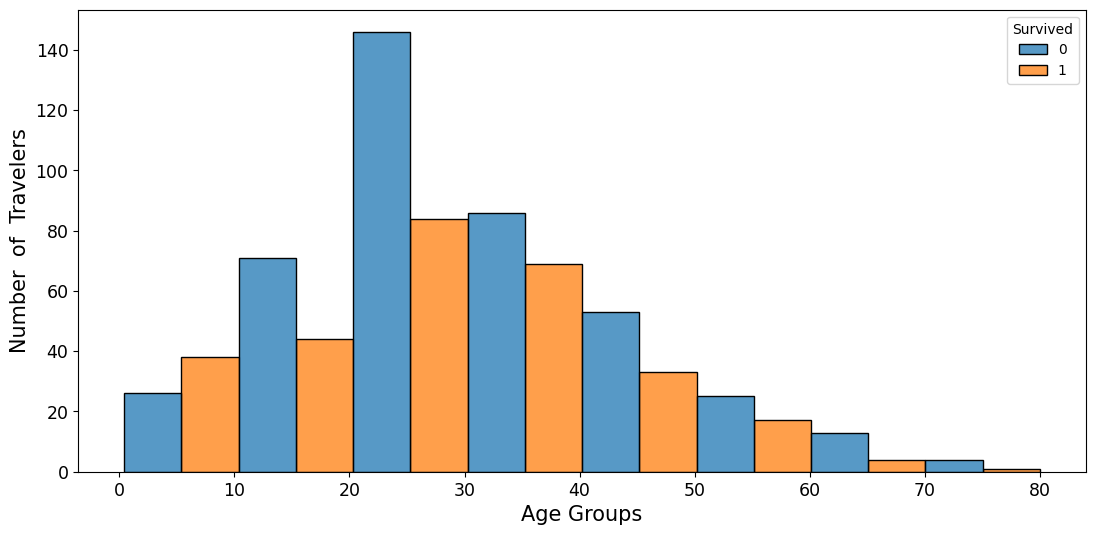

In [ ]:
df_pd = df.toPandas()
plt.rcParams["axes.labelsize"] = 15
plt.tick_params(labelsize=12.5)
ax = sns.histplot(data=df_pd, x="Age", hue="Survived",  multiple="dodge", bins=8)
ax.set(xlabel='Age Groups',
       ylabel='Number  of  Travelers')

In [ ]:
df.select('Age').distinct().count() #ນີ້ຄຶຄ່າທີ່ບໍ່ຊໍ້າກັນໃນຄໍລັນອາຍຸ

89

ເລີ່ມດໍາເນີນການ

In [ ]:
df.groupBy("Embarked","Survived").count().show()

+--------+--------+-----+
|Embarked|Survived|count|
+--------+--------+-----+
|    NULL|       1|    2|
|       Q|       1|   30|
|       S|       0|  427|
|       S|       1|  217|
|       C|       1|   93|
|       Q|       0|   47|
|       C|       0|   75|
+--------+--------+-----+



-ຄ່າໂດຍສານ

In [ ]:
df.groupBy("Fare","Survived").count().show(5)

+-------+--------+-----+
|   Fare|Survived|count|
+-------+--------+-----+
|   28.5|       0|    1|
|56.4958|       1|    5|
|  24.15|       0|    7|
|  120.0|       1|    4|
|  15.85|       0|    2|
+-------+--------+-----+
only showing top 5 rows



In [ ]:
df_pd.Fare.describe() #ນີ້ແມ່ນຄຳອະທິບາຍສະຖິຕິຂອງຖັນຄ່າໂດຍສານ

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

ແບ່ງ​ລັກສະນະ​ຄ່າ​ໂດຍສານ​ອອກ​ເປັນ 4 ປະ​ເພດ​ຕາມ​ອັດຕາ​ສ່ວນ:

In [ ]:
df_pd['Fare_Class'] = pd.cut(df_pd['Fare'], bins=[0,7.91,14.45,31,512.33], labels=['Low','Mid_Low-Mid','Mid-Mid_High','High'])

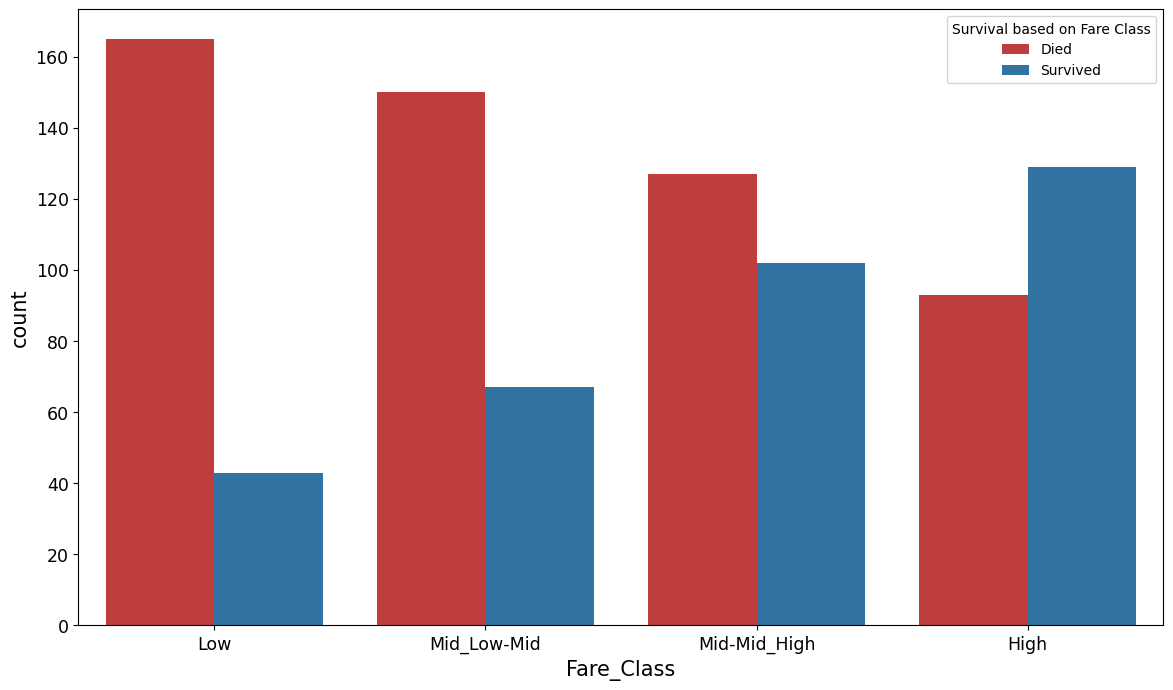

In [ ]:
plt.rcParams["figure.figsize"] = (14,8)
plt.rcParams["axes.labelsize"] = 15
plt.tick_params(labelsize=12.5)
ax_2 = sns.countplot(x = "Fare_Class", hue = "Survived", data = df_pd, palette=["C3", "C0"]).legend(labels = ["Died", "Survived"])
ax_2.set_title("Survival based on Fare Class")

- ປີ້:

In [ ]:
df.groupBy("Ticket","Survived").count().show(5)

+--------+--------+-----+
|  Ticket|Survived|count|
+--------+--------+-----+
|  330958|       1|    1|
|  350404|       0|    1|
|    2693|       0|    1|
|  349912|       0|    1|
|CA. 2343|       0|    7|
+--------+--------+-----+
only showing top 5 rows



In [ ]:
df.select('Ticket').distinct().count() #ນີ້ຄຶຄ່າທີ່ບໍ່ຊໍ້າກັນໃນຄໍລັນປີ້

681

ຕົວເລກຂອງປີ້ບໍ່ໄດ້ແປເປັນຄວາມຫມາຍທີ່ມີຄຸນຄ່າເພື່ອອະທິບາຍໂອກາດຂອງການຢູ່ລອດຂອງ passanger ໄດ້. ມັນເປັນສິ່ງທີ່ຄາດວ່າຈະມີຫຼັງຈາກເບິ່ງສະຖິຕິຄໍາອະທິບາຍທີ່ກ່ຽວຂ້ອງກັບຄຸນສົມບັດນີ້.

- ຫ້ອງໂດຍສານ:

In [ ]:
df.groupBy("Cabin", "Survived").count().show(5)

+-----+--------+-----+
|Cabin|Survived|count|
+-----+--------+-----+
|  C78|       0|    1|
|   F2|       0|    1|
|   A7|       0|    1|
|  D45|       1|    1|
|  C47|       1|    1|
+-----+--------+-----+
only showing top 5 rows



In [ ]:
df.select('Cabin').distinct().count() #ນີ້ຄຶຄ່າທີ່ບໍ່ຊໍ້າກັນໃນຄໍລັນຫ້ອງໂດຍສານ

148

ສິ່ງທີ່ພວກເຮົາເວົ້າກ່ຽວກັບປີ້ຄຸນນະສົມບັດແມ່ນຖືກຕ້ອງສໍາລັບຫ້ອງໂດຍສານຄຸນນະສົມບັດ: ມັນບໍ່ໄດ້ແປເປັນຄວາມຫມາຍທີ່ມີຄຸນຄ່າທີ່ຈະອະທິບາຍໂອກາດຂອງການຢູ່ລອດຂອງ passanger ໄດ້.
ນອກຈາກນັ້ນ, ດັ່ງທີ່ພວກເຮົາຈະເຫັນຂ້າງລຸ່ມນີ້, ຈໍານວນຄ່າທີ່ຂາດຫາຍໄປກ່ຽວກັບຕົວແປນີ້ມັນສູງຫຼາຍ, ທັງໃນຢ່າງແທ້ຈິງ (687) ແລະເງື່ອນໄຂທີ່ກ່ຽວຂ້ອງ (ປະມານ 77%).

# ຄຸນສົມບັດການຄັດເລືອກ: ໄລຍະທີ 1

In [ ]:
df_pyspark=df.drop('Cabin','Ticket','PassengerId')

In [ ]:
df_pyspark.show(5)

+--------+------+--------------------+------+----+-----+-----+-------+--------+
|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|   Fare|Embarked|
+--------+------+--------------------+------+----+-----+-----+-------+--------+
|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|   7.25|       S|
|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|71.2833|       C|
|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|  7.925|       S|
|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|   53.1|       S|
|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|   8.05|       S|
+--------+------+--------------------+------+----+-----+-----+-------+--------+
only showing top 5 rows



ຄຸນສົມບັດ 'ຊື່' ບໍ່ໄດ້ຖືກໂຍກຍ້າຍອອກເພາະວ່າມັນຈະສໍາຄັນສໍາລັບການຕື່ມຂໍ້ມູນໃສ່ໃນມູນຄ່າທີ່ຂາດຫາຍໄປກ່ຽວກັບອາຍຸຄຸນສົມບັດ.

ການປະເມີນຄ່າທີ່ຂາດຫາຍໄປ:
- ອາຍຸ:
ເພື່ອທົດແທນຄ່າທີ່ຂາດຫາຍໄປ, ພວກເຮົາສາມາດກຳນົດຄ່າສະເລ່ຍ ຫຼືອາຍຸປານກາງຂອງຊຸດຂໍ້ມູນໃຫ້ເຂົາເຈົ້າ. ຖ້າພວກເຮົາໃຊ້ຫນ້າທີ່ທີ່ແຕກຕ່າງກັນ () ແລະ count() ເຊັ່ນທີ່ພວກເຮົາໄດ້ເຮັດຂ້າງເທິງນີ້ສໍາລັບລັກສະນະອື່ນໆ, ພວກເຮົາຈະເຫັນວ່າມີຫຼາຍອາຍຸທີ່ແຕກຕ່າງກັນ, ພຽງແຕ່ເບິ່ງສະຖິຕິທີ່ອະທິບາຍກ່ຽວກັບຄຸນລັກສະນະຂອງອາຍຸຫນຶ່ງສາມາດບອກໄດ້ວ່າມັນຈະບໍ່ເປັນ. ເໝາະສົມທີ່ຈະລະບຸຄ່າສະເລ່ຍ ຫຼືອາຍຸປານກາງໃຫ້ກັບຄ່າທີ່ຂາດຫາຍໄປ.

ການສົມມຸດຕິຖານ: ອາຍຸແມ່ນປັດໃຈສໍາຄັນເມື່ອເວົ້າເຖິງອັດຕາການຢູ່ລອດ, ຕົວຢ່າງ, ກຸ່ມອາຍຸນ້ອຍທີ່ສຸດມີໂອກາດຢູ່ລອດສູງກວ່າຜູ້ສູງອາຍຸ.
ເຮືອ​ຊ່ວຍ​ຊີວິດ​ທີ່​ມີ​ຢູ່, ຕາມ​ລະບຽບ​ການ, ຕົ້ນຕໍ​ແມ່ນ​ໃຊ້​ເພື່ອ​ຊ່ວຍ​ຊີວິດ​ເດັກນ້ອຍ ​ແລະ ຜູ້ຍິງ.

ພວກເຮົາສາມາດໃຊ້ຕົວກອງ regex ເພື່ອແຍກຊື່ ແລະດໍາເນີນການນີ້ສໍາລັບທຸກໆແຖວຂອງ dataframe ແລະດັ່ງນັ້ນຈິ່ງຊອກຫາຜູ້ໂດຍສານທີ່ເປັນຜູ້ຍິງ ແລະເດັກນ້ອຍ (ພວກເຮົາຈະປັບປຸງຂັ້ນຕອນນີ້ໃນພາຍຫຼັງ ເພາະວ່າຜູ້ຍິງທີ່ບໍ່ໄດ້ແຕ່ງງານໃນທຸກໄວມີ 'ນາງສາວ'. ແນວໃດກໍ່ຕາມ, ໃນບັນດາເພດຍິງເຫຼົ່ານັ້ນມີເດັກຍິງໄວໜຸ່ມ ແລະ ເພດຍິງຜູ້ໃຫຍ່, ສ່ວນຫຼາຍແມ່ນ, ອາຍຸສະເລ່ຍທີ່ກ່ຽວຂ້ອງກັນ), ແລະ ຍັງເປັນເພດຊາຍຜູ້ໃຫຍ່ທີ່ມີປະເພດວິຊາອາຊີບ-ສັງຄົມທີ່ແຕກຕ່າງກັນ.
ຫຼັງຈາກສະກັດຫົວຂໍ້ແລ້ວພວກເຮົາຈະເຫັນວ່າອາຍຸສະເລ່ຍສາມາດແຕກຕ່າງກັນຢ່າງຫຼວງຫຼາຍສໍາລັບຫົວຂໍ້ທີ່ແຕກຕ່າງກັນ.

ພວກເຮົາຈະບໍ່ພຽງແຕ່ສະກັດຫົວຂໍ້ແລະກໍານົດອາຍຸສະເລ່ຍໃຫ້ກັບຄ່າທີ່ຂາດຫາຍໄປ, ພວກເຮົາຈະຖືກຕ້ອງຫຼາຍກວ່ານັ້ນໃນການລະບຸອາຍຸທີ່ຂາດຫາຍໄປຕາມທີ່ທ່ານຈະເຫັນໃນພາຍຫລັງ.

In [ ]:
from pyspark.sql.functions import mean,col,split, regexp_extract, lit
 #extract the title from the name column
df_pyspark = df_pyspark.withColumn("Title",regexp_extract(col("Name"),"([A-Za-z]+)\.",1))

In [ ]:
df_pyspark.show(5)

+--------+------+--------------------+------+----+-----+-----+-------+--------+-----+
|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|   Fare|Embarked|Title|
+--------+------+--------------------+------+----+-----+-----+-------+--------+-----+
|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|   7.25|       S|   Mr|
|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|71.2833|       C|  Mrs|
|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|  7.925|       S| Miss|
|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|   53.1|       S|  Mrs|
|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|   8.05|       S|   Mr|
+--------+------+--------------------+------+----+-----+-----+-------+--------+-----+
only showing top 5 rows



ໃຫ້ເບິ່ງຫົວຂໍ້ທີ່ແຕກຕ່າງກັນໃນຊຸດຂໍ້ມູນຂອງພວກເຮົາ:

In [ ]:
df_pyspark.select("Title").distinct().show()

+--------+
|   Title|
+--------+
|     Don|
|    Miss|
|Countess|
|     Col|
|     Rev|
|    Lady|
|  Master|
|     Mme|
|    Capt|
|      Mr|
|      Dr|
|     Mrs|
|     Sir|
|Jonkheer|
|    Mlle|
|   Major|
|      Ms|
+--------+



ມີຫົວຂໍ້ທີ່ສາມາດຈັດກຸ່ມເຂົ້າໄປໃນ "ປະເພດ" ດຽວກັນເຊັ່ນ, ຕົວຢ່າງ, 'Capt' ແລະ 'Major' ທັງສອງແມ່ນເຈົ້າຫນ້າທີ່.
ນອກຈາກນັ້ນ, ຍັງມີຫົວຂໍ້ທີ່ສະກົດຜິດຫຼືວ່າແຕກຕ່າງກັນແລະຖືກສະກົດຖືກຕ້ອງຫມາຍເຖິງສິ່ງດຽວກັນເຊັ່ນ: 'Mlle' ຫມາຍຄວາມວ່າ 'Miss', 'Mme' ຫມາຍຄວາມວ່າ 'ນາງ' ແລະ Ms ຫມາຍຄວາມວ່າ "Miss".
ກ່ຽວກັບ 'Dr' ແລະ 'Rev' ພວກເຮົາເລືອກທີ່ຈະທົດແທນພວກມັນດ້ວຍ 'ອື່ນໆ'.

ໃຫ້ປ່ຽນຊື່ຫົວຂໍ້ຕາມເຫດຜົນຂອງພວກເຮົາ:

In [ ]:
df_pyspark = df_pyspark.replace(['Capt','Col', 'Major', 'Jonkheer','Don','Sir','Dr','Rev','Countess','Mme','Mlle','Ms','Lady'],
               ['Officer','Officer','Officer','Royalty','Royalty', 'Royalty', 'Other','Other', 'Royalty', "Mrs", "Miss", 'Miss', "Royalty"])

In [ ]:
df_pyspark.show(20)

+--------+------+--------------------+------+----+-----+-----+-------+--------+------+
|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|   Fare|Embarked| Title|
+--------+------+--------------------+------+----+-----+-----+-------+--------+------+
|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|   7.25|       S|    Mr|
|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|71.2833|       C|   Mrs|
|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|  7.925|       S|  Miss|
|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|   53.1|       S|   Mrs|
|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|   8.05|       S|    Mr|
|       0|     3|    Moran, Mr. James|  male|NULL|    0|    0| 8.4583|       Q|    Mr|
|       0|     1|McCarthy, Mr. Tim...|  male|54.0|    0|    0|51.8625|       S|    Mr|
|       0|     3|Palsson, Master. ...|  male| 2.0|    3|    1| 21.075|       S|Master|
|       1|     3|Johnson, Mrs. Osc...|femal

ຜູ້ຍິງທີ່ບໍ່ໄດ້ແຕ່ງງານທັງໝົດໃນທຸກເພດທຸກໄວມີຫົວຂໍ້ 'ນາງສາວ'. ຢ່າງໃດກໍຕາມ, ໃນບັນດາແມ່ຍິງເຫຼົ່ານັ້ນ, ມີເດັກຍິງໄວຫນຸ່ມແລະແມ່ຍິງຜູ້ໃຫຍ່ທີ່ມີ, ສ່ວນຫຼາຍອາດຈະ, ອາຍຸສະເລ່ຍທີ່ແຕກຕ່າງກັນ.
ມີເຫດຜົນທີ່ພວກເຮົາອາດຈະໃຊ້ເພື່ອຈໍາແນກທັງສອງກໍລະນີ: ຖ້າ Parch > 0, ສ່ວນຫຼາຍອາດຈະເປັນເດັກນ້ອຍແມ່ຍິງທີ່ເດີນທາງກັບພໍ່ແມ່ຢ່າງຫນ້ອຍຫນຶ່ງຄົນ (ພວກເຮົາຈະຕັ້ງຊື່ເປັນ 'MissPar'); ຖ້າ Parch = 0, ມັນອາດຈະວ່າພວກເຂົາເປັນເພດຍິງຜູ້ໃຫຍ່ທີ່ເດີນທາງຄົນດຽວ (ພວກເຮົາຈະຕັ້ງຊື່ເປັນ 'MissA').

ໃຫ້ພວກເຮົາກວດເບິ່ງວ່າອາຍຸສະເລ່ຍຂອງສອງກໍລະນີແຕກຕ່າງກັນແນວໃດ:

In [ ]:
print("ອາຍຸສະເລ່ຍຂອງນາງສາວເດີນທາງໂດຍບໍ່ມີຜູ້ປົກຄອງ 'MissA'", df_pyspark[(df_pyspark.Title=="Miss") & (df_pyspark.Parch==0)].agg(mean('Age').alias('mean')).collect())
print("ອາຍຸສະເລ່ຍຂອງນາງສາວເດີນທາງກັບຜູ້ປົກຄອງ 'MissPar'", df_pyspark[(df_pyspark.Title=="Miss") & (df_pyspark.Parch!=0)].agg(mean('Age').alias('mean')).collect())

ອາຍຸສະເລ່ຍຂອງນາງສາວເດີນທາງໂດຍບໍ່ມີຜູ້ປົກຄອງ 'MissA' [Row(mean=27.68617021276596)]
ອາຍຸສະເລ່ຍຂອງນາງສາວເດີນທາງກັບຜູ້ປົກຄອງ 'MissPar' [Row(mean=11.863636363636363)]


ຄໍາເຫັນ: ຄວາມແຕກຕ່າງລະຫວ່າງອາຍຸສະເລ່ຍຂອງສອງກໍລະນີທີ່ແຕກຕ່າງກັນແມ່ນສັງເກດເຫັນ!
ດ້ວຍເຫດນີ້, ຂໍໃຫ້ເພີ່ມຄໍລໍາທີ່ມີຫົວຂໍ້ໃຫມ່ສໍາລັບແຕ່ລະກໍລະນີເຫຼົ່ານັ້ນທົດແທນຫົວຂໍ້ 'Miss' ໂດຍ 'MissA' ແລະ 'MissPar' ຕາມຄວາມເຫມາະສົມ:

In [ ]:
# ອາຍຸສະເລ່ຍຂອງນາງສາວເດີນທາງໂດຍບໍ່ມີຜູ້ປົກຄອງ 'MissA' [Row(mean=21.773972602739725)]
df_pyspark = df_pyspark.withColumn("NewTitle",
                        when((df_pyspark.Title=="Miss") & (df_pyspark.Parch==0), 'MissA')
                       .when((df_pyspark.Title=="Miss") & (df_pyspark.Parch!=0), 'MissPar')
                       .otherwise(df_pyspark['Title']))

In [ ]:
df_pyspark.show(20)

+--------+------+--------------------+------+----+-----+-----+-------+--------+------+--------+
|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|   Fare|Embarked| Title|NewTitle|
+--------+------+--------------------+------+----+-----+-----+-------+--------+------+--------+
|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|   7.25|       S|    Mr|      Mr|
|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|71.2833|       C|   Mrs|     Mrs|
|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|  7.925|       S|  Miss|   MissA|
|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|   53.1|       S|   Mrs|     Mrs|
|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|   8.05|       S|    Mr|      Mr|
|       0|     3|    Moran, Mr. James|  male|NULL|    0|    0| 8.4583|       Q|    Mr|      Mr|
|       0|     1|McCarthy, Mr. Tim...|  male|54.0|    0|    0|51.8625|       S|    Mr|      Mr|
|       0|     3|Palsson, Master. ...|  

ເພື່ອໃຫ້ຖືກຕ້ອງຫຼາຍຂຶ້ນໃນການຄິດໄລ່ອາຍຸທີ່ຂາດຫາຍໄປ, ພວກເຮົາຈະຄິດໄລ່ອາຍຸສະເລ່ຍຂອງກຸ່ມຜູ້ໂດຍສານທີ່ຄ້າຍຄືກັນໂດຍພິຈາລະນາລັກສະນະບາງຢ່າງທີ່ປະສົມປະສານ.

ສໍາລັບວ່າ, ເນື່ອງຈາກຄວາມແຕກຕ່າງຢ່າງຫຼວງຫຼາຍກ່ຽວກັບອັດຕາການລອດຊີວິດທີ່ແທ້ຈິງລະຫວ່າງສາມຊັ້ນຮຽນທີ່ແຕກຕ່າງກັນ (Pclass1, Pclass2 ແລະ Pclass3), ພວກເຮົາຈະຈັດກຸ່ມລັກສະນະ NewTitle ແລະ Pclass ເພື່ອກໍານົດກຸ່ມຂອງຜູ້ໂດຍສານທີ່ຄ້າຍຄືກັນ (ໃນສິ່ງທີ່ກ່ຽວຂ້ອງກັບສອງລັກສະນະເຫຼົ່ານັ້ນ) ແລະ. ຈາກນັ້ນຊອກຫາອາຍຸສະເລ່ຍຂອງຜູ້ໂດຍສານທີ່ຄ້າຍຄືກັນເຫຼົ່ານັ້ນ:

In [ ]:
my_list = df_pyspark.groupby(['NewTitle', 'Pclass']).avg(('Age')).collect()

In [ ]:
spark.createDataFrame(my_list).show()

+--------+------+------------------+
|NewTitle|Pclass|          avg(Age)|
+--------+------+------------------+
|   MissA|     2|            30.375|
|     Mrs|     3|33.515151515151516|
|      Mr|     1| 41.58045977011494|
|   Other|     1|             43.75|
| MissPar|     3| 6.903846153846154|
| MissPar|     1|              21.0|
|   MissA|     1| 34.25806451612903|
|     Mrs|     1|              40.4|
|   Other|     2|              42.0|
|      Mr|     2| 32.76829268292683|
|  Master|     3| 5.350833333333334|
|   MissA|     3|21.697674418604652|
| Officer|     1|              56.6|
|      Mr|     3|28.724890829694324|
| Royalty|     1|              41.6|
|  Master|     2|2.2588888888888885|
|  Master|     1| 5.306666666666667|
| MissPar|     2|10.538461538461538|
|     Mrs|     2| 33.68292682926829|
+--------+------+------------------+



ມາເພີ່ມຖັນ ('AgeImputed') ແລະປ່ຽນແທນຄ່າ 'ອາຍຸ' ທີ່ຂາດໄປ ໂດຍກຳນົດອາຍຸສະເລ່ຍຂອງຜູ້ໂດຍສານທີ່ຄ້າຍຄືກັນ:

In [ ]:
# ໃນທີ່ນີ້ພວກເຮົາກໍາລັງຄິດໄລ່ຄ່າທີ່ຂາດຫາຍໄປຂອງຖັນອາຍຸກັບອາຍຸສະເລ່ຍຂອງຜູ້ໂດຍສານທີ່ມີຫົວຂໍ້ດຽວກັນແລະຊັ້ນຮຽນ.
df_pyspark = df_pyspark.withColumn("AgeImputed",
                         when((df_pyspark.NewTitle=="Mr") & (df_pyspark.Pclass==3) & (df_pyspark.Age.isNull()), 28.72)
                        .when((df_pyspark.NewTitle=="Mr") & (df_pyspark.Pclass==2) & (df_pyspark.Age.isNull()), 32.77)
                        .when((df_pyspark.NewTitle=="Mr") & (df_pyspark.Pclass==1) & (df_pyspark.Age.isNull()), 41.58)
                        .when((df_pyspark.NewTitle=="Mrs") & (df_pyspark.Pclass==3) & (df_pyspark.Age.isNull()), 33.5)
                        .when((df_pyspark.NewTitle=="Mrs") & (df_pyspark.Pclass==2) & (df_pyspark.Age.isNull()), 33.68)
                        .when((df_pyspark.NewTitle=="Mrs") & (df_pyspark.Pclass==1) & (df_pyspark.Age.isNull()), 40.4)
                        .when((df_pyspark.NewTitle=="Other") & (df_pyspark.Pclass==2) & (df_pyspark.Age.isNull()), 42)
                        .when((df_pyspark.NewTitle=="Other") & (df_pyspark.Pclass==1) & (df_pyspark.Age.isNull()), 43.8)
                        .when((df_pyspark.NewTitle=="MissA") & (df_pyspark.Pclass==3) & (df_pyspark.Age.isNull()), 21.7)
                        .when((df_pyspark.NewTitle=="MissA") & (df_pyspark.Pclass==2) & (df_pyspark.Age.isNull()), 30.38)
                        .when((df_pyspark.NewTitle=="MissA") & (df_pyspark.Pclass==1) & (df_pyspark.Age.isNull()), 34.26)
                        .when((df_pyspark.NewTitle=="MissPar") & (df_pyspark.Pclass==3) & (df_pyspark.Age.isNull()), 6.9)
                        .when((df_pyspark.NewTitle=="MissPar") & (df_pyspark.Pclass==2) & (df_pyspark.Age.isNull()), 10.54)
                         .when((df_pyspark.NewTitle=="MissPar") & (df_pyspark.Pclass==1) & (df_pyspark.Age.isNull()), 21)
                        .when((df_pyspark.NewTitle=="Master") & (df_pyspark.Pclass==3) & (df_pyspark.Age.isNull()), 5.35)
                        .when((df_pyspark.NewTitle=="Master") & (df_pyspark.Pclass==2) & (df_pyspark.Age.isNull()), 2.26)
                        .when((df_pyspark.NewTitle=="Master") & (df_pyspark.Pclass==1) & (df_pyspark.Age.isNull()), 5.31)
                        .when((df_pyspark.NewTitle=="Officer|") & (df_pyspark.Pclass==1) & (df_pyspark.Age.isNull()), 56.6)
                        .when((df_pyspark.NewTitle=="Royalty|") & (df_pyspark.Pclass==1) & (df_pyspark.Age.isNull()), 41.6)
                        .otherwise(df_pyspark.Age))


ເລີ່ມຕົ້ນ:
ຄຸນນະສົມບັດນີ້ມີພຽງແຕ່ສອງຄ່າທີ່ຂາດຫາຍໄປແລະເກືອບ 3/4 ຂອງຜູ້ໂດຍສານທີ່ຂຶ້ນຈາກ "S" (Southampton). ພວກເຮົາຈະ impute "S".

In [ ]:
df_pyspark = df_pyspark.na.fill({"Embarked" : 'S'})

In [ ]:
df_pyspark.show(20)

+--------+------+--------------------+------+----+-----+-----+-------+--------+------+--------+----------+
|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|   Fare|Embarked| Title|NewTitle|AgeImputed|
+--------+------+--------------------+------+----+-----+-----+-------+--------+------+--------+----------+
|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|   7.25|       S|    Mr|      Mr|      22.0|
|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|71.2833|       C|   Mrs|     Mrs|      38.0|
|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|  7.925|       S|  Miss|   MissA|      26.0|
|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|   53.1|       S|   Mrs|     Mrs|      35.0|
|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|   8.05|       S|    Mr|      Mr|      35.0|
|       0|     3|    Moran, Mr. James|  male|NULL|    0|    0| 8.4583|       Q|    Mr|      Mr|     28.72|
|       0|     1|McCarthy, Mr. Tim...

# 6. ຄຸນສົມບັດການຄັດເລືອກ: ໄລຍະທີ 2

ການເອົາຄຸນສົມບັດທີ່ບໍ່ຈໍາເປັນອອກຫຼັງຈາກ FEATURE ENGINEERING:

In [ ]:
df_pyspark=df_pyspark.drop('Name','Age','Title')

ໃຫ້ກວດເບິ່ງວ່າຍັງມີຄ່າໃດທີ່ຂາດຫາຍໄປ:

In [ ]:
df_pyspark.select([count(when(isnan(c)|col(c).isNull(),c)).alias(c) for c in df_pyspark.columns]).show()

+--------+------+---+-----+-----+----+--------+--------+----------+
|Survived|Pclass|Sex|SibSp|Parch|Fare|Embarked|NewTitle|AgeImputed|
+--------+------+---+-----+-----+----+--------+--------+----------+
|       0|     0|  0|    0|    0|   0|       0|       0|         0|
+--------+------+---+-----+-----+----+--------+--------+----------+



ກວດເບິ່ງ schema ຫຼັງຈາກການປ່ຽນແປງທີ່ພວກເຮົາເຮັດ:

In [ ]:
df_pyspark.printSchema()

root
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Embarked: string (nullable = false)
 |-- NewTitle: string (nullable = true)
 |-- AgeImputed: double (nullable = true)



ມາເຮັດວິສະວະກໍາຄຸນສົມບັດເພີ່ມເຕີມບາງອັນ:

ສ້າງຟັງຊັນເພື່ອປ່ຽນຄຸນລັກສະນະປະເພດເປັນ vector binary ທີ່ມີຄ່າສູງສຸດອັນດຽວຕໍ່ແຖວທີ່ຊີ້ບອກດັດສະນີໝວດໝູ່ການປ້ອນຂໍ້ມູນ (ໂດຍໃຊ້ OneHotEncoder), ໝວດໝູ່ສຸດທ້າຍບໍ່ໄດ້ລວມຢູ່ຕາມຄ່າເລີ່ມຕົ້ນ), ແຕ່ທຳອິດໃຫ້ປ່ຽນຂໍ້ມູນທີ່ບໍ່ແມ່ນຕົວເລກເປັນ ຂໍ້ມູນຕົວເລກ (ໂດຍໃຊ້ StringIndexer):

In [ ]:
stages=[]
cat=['Sex','Embarked','Pclass','NewTitle']

In [ ]:
for catCol in cat:
    indexer = StringIndexer(inputCol=catCol, outputCol=catCol+'Index',stringOrderType='frequencyDesc')
    encoder=OneHotEncoder(inputCols=[indexer.getOutputCol()],outputCols=[catCol+'catVec'])
    stages+=[indexer,encoder]

stages

[StringIndexer_b3067c802b45,
 OneHotEncoder_f0671c267c6f,
 StringIndexer_a30c713c2b95,
 OneHotEncoder_4f57493c0a1c,
 StringIndexer_73eaf8f1725f,
 OneHotEncoder_5f543e2b586a,
 StringIndexer_8fd39c564a78,
 OneHotEncoder_685ed7e3744b]

ໃຫ້ພວກເຮົາລວມເອົາບັນຊີລາຍຊື່ຂອງຄໍລໍາທີ່ຫນ້າສົນໃຈຂອງພວກເຮົາເຂົ້າໄປໃນຄໍລໍາ vector ດຽວທີ່ມີຊື່ຢ່າງຖືກຕ້ອງ 'ຄຸນສົມບັດ' (ໃຊ້ VectorAssembler):

In [ ]:
numeric=['Fare','SibSp','Parch','AgeImputed']

In [ ]:
assembleInputs=[c+'catVec' for c in cat]+numeric
assembler=VectorAssembler(inputCols=assembleInputs,outputCol="features")
stages+=[assembler]

# 7. ການແປງຂໍ້ມູນທົດສອບ

ຕອນນີ້ເຮົາມາແຍກການ train-test

In [ ]:
train_data, test_data = df_pyspark.randomSplit([0.8,0.2],seed=42)

In [ ]:
# pipeline
pipeline=Pipeline().setStages(stages)
pipelineModel=pipeline.fit(train_data)

ແປງຂໍ້ມູນ ທົດສອບ ແລະ test

In [ ]:
train_pipe=pipelineModel.transform(train_data)
test_pipe=pipelineModel.transform(test_data)

In [ ]:
train_pipe.head(1)

[Row(Survived=0, Pclass=1, Sex='female', SibSp=0, Parch=0, Fare=28.7125, Embarked='C', NewTitle='MissA', AgeImputed=50.0, SexIndex=1.0, SexcatVec=SparseVector(1, {}), EmbarkedIndex=1.0, EmbarkedcatVec=SparseVector(2, {1: 1.0}), PclassIndex=1.0, PclasscatVec=SparseVector(2, {1: 1.0}), NewTitleIndex=1.0, NewTitlecatVec=SparseVector(7, {1: 1.0}), features=SparseVector(16, {2: 1.0, 4: 1.0, 6: 1.0, 12: 28.7125, 15: 50.0}))]

# 8. ການຈັດໜວດໝູ່

- ແບບຈໍາລອງພື້ນຖານ ແລະ ການປະມວນຜົນ

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

In [ ]:
# ຈໍາແນກປະເພດແບບສຸ່ມ
rf = RandomForestClassifier(labelCol = 'Survived', predictionCol='prediction', seed=42)
rfmodel = rf.fit(train_pipe)

In [ ]:
pred_results_rf = rfmodel.transform(test_pipe)

In [ ]:
 # ສໍາລັບຊຸດຝືກສອນ
summary=rfmodel.summary
summary.accuracy

0.839142091152815

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol='Survived')

rfevaluator=evaluator.evaluate(pred_results_rf)
# equal to:
auroc = evaluator.evaluate(pred_results_rf, {evaluator.metricName: "areaUnderROC"})

aupr= evaluator.evaluate(pred_results_rf, {evaluator.metricName: "areaUnderPR"})
print('ພື້ນທີ່ພາຍໃຕ້ເສັ້ນໂຄ້ງ ROC: ',auroc)
print('ພື້ນທີ່ພາຍໃຕ້ເສັ້ນໂຄ້ງ PR: ',aupr)

ພື້ນທີ່ພາຍໃຕ້ເສັ້ນໂຄ້ງ ROC:  0.8982240437158471
ພື້ນທີ່ພາຍໃຕ້ເສັ້ນໂຄ້ງ PR:  0.891833388917776


ການປັບແຕ່ງ Hyperparameter ດ້ວຍ CrossValidator ແລະ ການປະເມີນຜົນ:

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder,CrossValidator
rfparamGrid = (ParamGridBuilder()
               .addGrid(rf.maxDepth, [2, 4, 5])
               .addGrid(rf.numTrees, [5, 10, 20, 100])
             .build())

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluatorRF=BinaryClassificationEvaluator(labelCol='Survived')

cv = CrossValidator(estimator = rf,
                      estimatorParamMaps = rfparamGrid,
                      evaluator = evaluatorRF,
                      numFolds = 5)

rfcv=cv.fit(train_pipe)

In [ ]:
# ເຮັດການຄາດເດົາກ່ຽວກັບເອກະສານການທົດສອບ. cvModel ໃຊ້ຮູບແບບທີ່ດີທີ່ສຸດທີ່ພົບເຫັນ (lrModel).
predictions=rfcv.bestModel.transform(test_pipe)
evaluatorRF.evaluate(predictions)

0.8982240437158471

In [ ]:
# ໃນຖານະເປັນ, ໂດຍຄ່າເລີ່ມຕົ້ນ, ຊື່ metric ຂອງ BinaryClassificationEvaluator ແມ່ນ areaUnderROC ຄ່າທໍາອິດຈະເທົ່າກັບຕາລາງຂ້າງເທິງ.
auroc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
aupr= evaluatorRF.evaluate(predictions, {evaluatorRF.metricName: "areaUnderPR"})
print('ພື້ນທີ່ພາຍໃຕ້ເສັ້ນໂຄ້ງ ROC: ',auroc)
print('ພື້ນທີ່ພາຍໃຕ້ເສັ້ນໂຄ້ງ PR: ',aupr)

ພື້ນທີ່ພາຍໃຕ້ເສັ້ນໂຄ້ງ ROC:  0.8982240437158471
ພື້ນທີ່ພາຍໃຕ້ເສັ້ນໂຄ້ງ PR:  0.891833388917776


ພວກ​ເຮົາ​ສາ​ມາດ​ໄດ້​ຮັບ​ຄວາມ​ຖືກ​ຕ້ອງ​ແລະ F1 ຄະ​ແນນ​ໂດຍ​ການ​ນໍາ​ໃຊ້ MulticlassClassificationEvaluator ທີ່​ສາ​ມາດ​ນໍາ​ໃຊ້​ສໍາ​ລັບ​ການ​ຈັດ​ປະ​ເພດ​ຄູ່​ເຊັ່ນ​ດຽວ​ກັນ​. ໃຫ້ໃຊ້ມັນເພື່ອຄວາມຖືກຕ້ອງ:

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [ ]:
multi_evaluator = MulticlassClassificationEvaluator(labelCol="Survived", predictionCol="prediction", metricName="accuracy")
rf_accuracy = multi_evaluator.evaluate(predictions)
print("ຄວາມຖືກຕ້ອງຂອງ RandomForestClassifier ແມ່ນ = ", (rf_accuracy))

ຄວາມຖືກຕ້ອງຂອງ RandomForestClassifier ແມ່ນ =  0.8482758620689655


 ການປະເມີນຜົນແບບຈໍາລອງກັບ SciKit-Learn: Classification Report

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
y_true = predictions.select(['Survived']).collect()
y_pred = predictions.select(['prediction']).collect()

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.93      0.88        84
           1       0.88      0.74      0.80        61

    accuracy                           0.85       145
   macro avg       0.86      0.83      0.84       145
weighted avg       0.85      0.85      0.85       145



# ສະຫຼຸບ:


1. ຫຼັງຈາກສໍາເລັດແລ້ວ,ພວກເຮົາໄດ້ບັນລຸເປົ້າຫມາຍທີ່ພວກເຮົາໄດ້ກໍານົດເອງໃຫ້ຄະແນນທີ່ພວກເຮົາບັນລຸໄດ້ສໍາລັບ metrics ທີ່ໃຊ້ທົ່ວໄປສໍາລັບຊຸດຂໍ້ມູນນີ້ກັບ Pyspark.
2. ຄະແນນທີ່ພວກເຮົາບັນລຸໄດ້ສໍາລັບ metrics ແມ່ນສູງກວ່າການນໍາໃຊ້ການປັບ  hyperparameter ກັບ CrossValidator ກ່ວາທີ່ພວກເຮົາໄດ້ບັນລຸກັບຕົວແບບພື້ນຖານ, ຕາມທີ່ຄາດໄວ້.
3. ຮູບແບບສາມາດໄດ້ຮັບການປັບປຸງເລັກນ້ອຍ, ຄືໃນສິ່ງທີ່ກ່ຽວຂ້ອງກັບການ imputation ຄຸນຄ່າຂອງອາຍຸທີ່ຂາດຫາຍໄປແລະໂດຍການນໍາໃຊ້ການຈັດປະເພດຫຼາຍ.